In [113]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import sys

from circuit_extract import visualize_circuit_masks
import circuit_extract as ce
import inference
import train

In [114]:
import importlib

importlib.reload(inference)
importlib.reload(train)
importlib.reload(ce)

<module 'circuit_extract' from '/home/cabbagepatch/Code/MI/vast/Mechanistic-Interpretability/circuit_extract.py'>

In [3]:
def model_config(ds_name: str, lr: float, epochs: int, seed: int=0):
    return {
        "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        "seed": seed,
        "dataset": ds_name,
        "epochs": epochs, 
        "lr": lr,
        # "pfrac": pfrac,
    }

def circuit_config(ds_name: str, lr: float, cepochs: int, k_w: int, seed: int=0):
    return {
        "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        "seed": seed,
        "dataset": ds_name,
        "cepochs": cepochs, 
        "lr": lr,
        "k_w": k_w,
    }
    

### Train Sparse Model ###

In [63]:
print("\n--- Phase 1: Initialize Model ---")
inp_shape = (1, 28, 28)
model = inference.CNN(nc=1, nf=16, num_classes=10, inp_shape=inp_shape)


--- Phase 1: Initialize Model ---


In [64]:
print("\n--- Phase 2: Train Sparse Baseline ---")
def scheduler(start, end, start_sparsity, target_sparsity, alpha):
    def f(epochs):
        t = min(max(0, epochs-start), end-start)/ (end-start)
        t = t**alpha
        return (target_sparsity* t + (1-t) * start_sparsity)
    return f

sched = scheduler(3, 12, 1, 0.1, 0.5)
# sched(0)
# for epoch in range(1,12):
#     print(sched(epoch+1))

cfg = model_config(ds_name='mnist', lr=1e-3, epochs=12)
device = cfg['device']
print(f"Running on {device}")

train.train_model(
    model=model,
    lr=cfg['lr'],
    b1=0.9, b2=0.999,
    # pfrac=cfg['pfrac'],
    scheduler = sched, 
    ds_name="mnist-baseline",
    eps=1e-8,
    epochs=cfg['epochs'],
    device=device,
    seed=cfg['seed']
)


--- Phase 2: Train Sparse Baseline ---
Running on cpu
n_params 20490 n_params_wd 20432
cpu
Epoch 0 | Train Acc: 0.9549 | Test Acc: 0.9573
Epoch 1 | Train Acc: 0.9732 | Test Acc: 0.9753
Epoch 2 | Train Acc: 0.9811 | Test Acc: 0.9804
Epoch 3 | Train Acc: 0.9828 | Test Acc: 0.9825
Epoch 4 | Train Acc: 0.9858 | Test Acc: 0.9832
Epoch 5 | Train Acc: 0.9874 | Test Acc: 0.9855
Epoch 6 | Train Acc: 0.9882 | Test Acc: 0.9858
Epoch 7 | Train Acc: 0.9882 | Test Acc: 0.9866
Epoch 8 | Train Acc: 0.9871 | Test Acc: 0.9858
Epoch 9 | Train Acc: 0.9867 | Test Acc: 0.9856
Epoch 10 | Train Acc: 0.9839 | Test Acc: 0.9838
Epoch 11 | Train Acc: 0.9777 | Test Acc: 0.9755


In [65]:
print(f'CUDA available: {torch.cuda.is_available()}') 
print(f'Device count: {torch.cuda.device_count()}')
print(f'Current device: {torch.cuda.current_device() if torch.cuda.is_available() else None}')


CUDA available: False
Device count: 0
Current device: None


In [66]:
non_zero = sum([(p != 0).sum() for p in model.parameters()])
total = sum([p.numel() for p in model.parameters()])

print(f"{non_zero/total:.4f}")

# when retaining also retain other ones
# scheduler also add (50 percent of training steos then reach sparsity)
# iteratively sparsify features after starting from 0 percent sparsty
# circuits should not rely on 
# for every neuron retain some weights
# try pretraining on generation
#try on more complex datasets, cmnist, cifar10, pacs
#maybe try portability
#try training on
#try the weird loss thing
#mistake : apply sigmoid estimator
#see this as an angle to improve DG
#how to work with circuits that are not end to end // have to use bigger models
#ha405 // visual reasoning
#how to find neurons/circuits correspoding to sprurious features / circuits
#work with different circuits in cross-domain settings
#randomization makes network more generalizable
#maybe try and find work in compilers?
#LLMs ka kaam karo
#senior



0.0999


### Extracting circuit for each class

In [119]:
def run_class_circuit(class_idx: int, model, epochs=9, l0_lambda=0.05):
    """
    Extracts and visualizes a circuit for a specific target class (0-9).
    """
    print(f" Processing Class {class_idx} ")
    
    ds_name = f"custom-{class_idx}"
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    print(f"Configuration: Device={device}, Lambda={l0_lambda}, Dataset={ds_name}")

    circuit = train.extract_circuit(
        model=model,
        lr=1e-2,
        b1=0.9, b2=0.999,
        ds_name=ds_name,     
        eps=1e-8,
        epochs=epochs,
        device=device,
        l0_lambda=l0_lambda,
        seed=42
    )

    print(f"\n--- Visualizing Circuit for Class {class_idx} ---")
    
    try:
        visualize_circuit_masks(circuit) 
        
        import os
        if os.path.exists("circuit_visualization.png"):
            os.rename("circuit_visualization.png", f"circuit_viz_class_{class_idx}.png")
            print(f"Saved visualization to: circuit_viz_class_{class_idx}.png")
            
    except Exception as e:
        print(f"Visualization failed: {e}")

    return circuit

 Processing Class 1 
Configuration: Device=cpu, Lambda=0.002, Dataset=custom-1


/home/cabbagepatch/miniconda3/envs/new/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(
/home/cabbagepatch/miniconda3/envs/new/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Calculating mean activations...
Initializing Circuit...
Extracting Circuit (L0 Lambda=0.002)...
Epoch 0 | Loss: 87.8923 | Avg Mask: 0.790 | Total Non-Zero: 43914.0 | | Circuit Acc: 0.9755
Epoch 1 | Loss: 87.8923 | Avg Mask: 0.587 | Total Non-Zero: 43914.0 | | Circuit Acc: 0.9755
Epoch 2 | Loss: 87.8873 | Avg Mask: 0.349 | Total Non-Zero: 43879.0 | | Circuit Acc: 0.9752
Epoch 3 | Loss: 74.2685 | Avg Mask: 0.091 | Total Non-Zero: 2075.0 | | Circuit Acc: 0.6632
Epoch 4 | Loss: 2.7443 | Avg Mask: -0.143 | Total Non-Zero: 494.0 | | Circuit Acc: 0.4235
Epoch 5 | Loss: 2.0918 | Avg Mask: -0.324 | Total Non-Zero: 418.0 | | Circuit Acc: 0.4016
Epoch 6 | Loss: 1.9978 | Avg Mask: -0.453 | Total Non-Zero: 383.0 | | Circuit Acc: 0.3841
Epoch 7 | Loss: 1.9576 | Avg Mask: -0.547 | Total Non-Zero: 354.0 | | Circuit Acc: 0.3746
Epoch 8 | Loss: 1.9159 | Avg Mask: -0.620 | Total Non-Zero: 338.0 | | Circuit Acc: 0.3884
Epoch 9 | Loss: 1.8939 | Avg Mask: -0.680 | Total Non-Zero: 329.0 | | Circuit Acc: 0.37

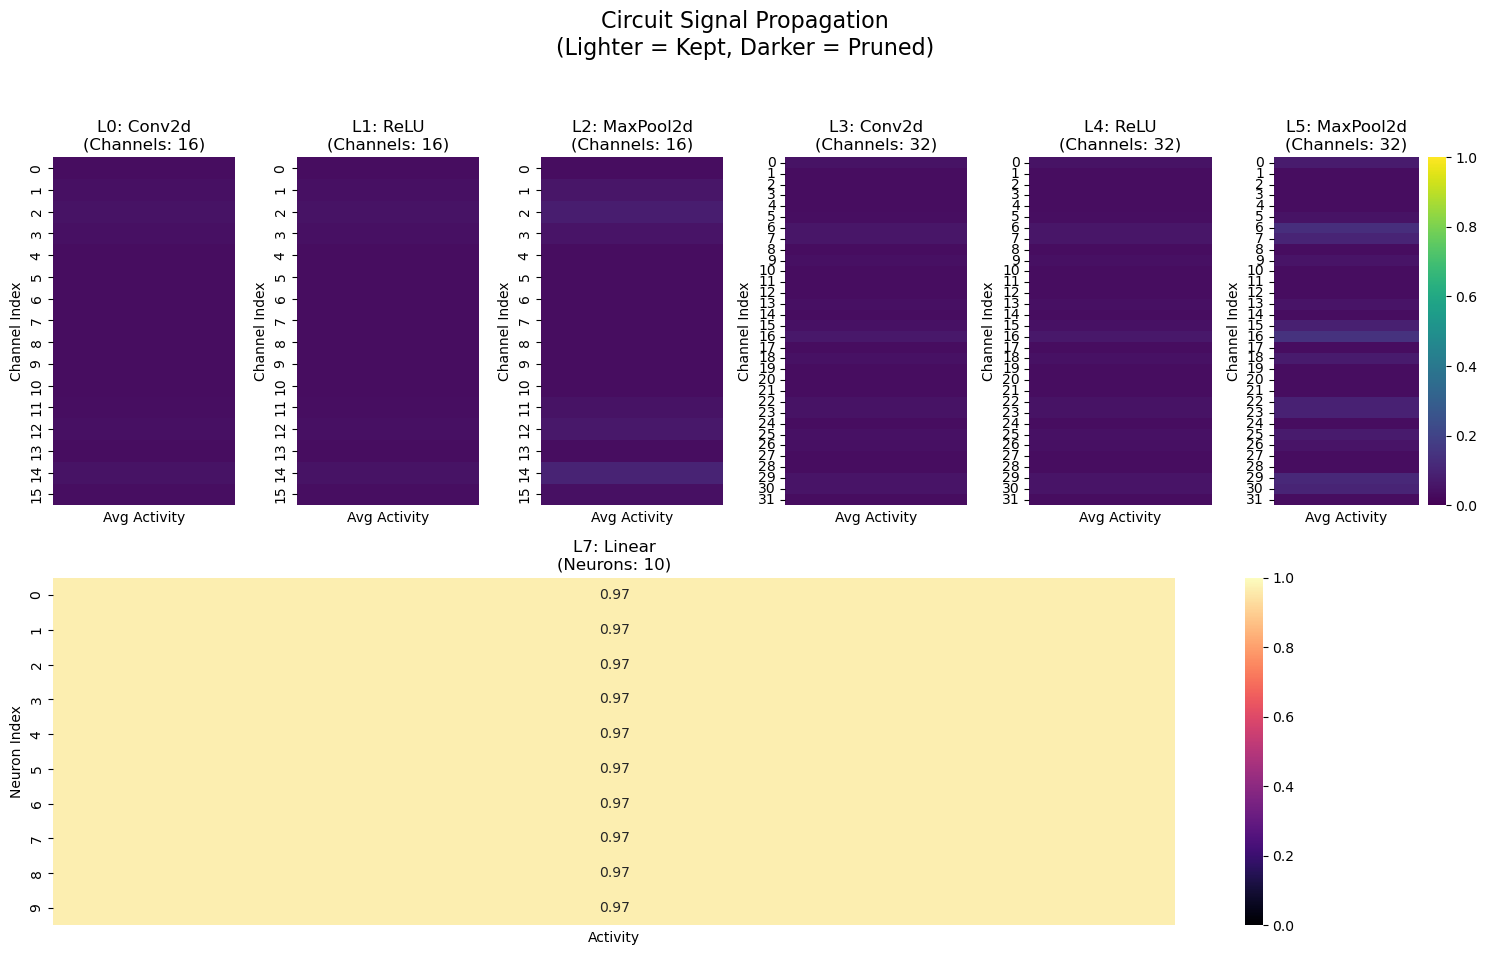


Visualization saved to circuit_visualization.png
Saved visualization to: circuit_viz_class_1.png


In [122]:
circuit_0 = run_class_circuit(class_idx=1, model=model, epochs=20,l0_lambda=0.002)

In [ ]:
# import random
# def resampler(labels: list[any], class_probs: dict[any, float], n: int):
    
#     classes = np.unique(labels)
#     class_idxs = {cls:[] for cls in classes}

#     for idx, cls in enumerate(labels):
#         class_idxs[cls].append(idx)
    
#     for _, v in class_idxs.items():
#         random.shuffle(v)

#     ret = []
#     for cls in classes:
#         idxs, prob = class_idxs[cls], class_probs[cls]
#         ret += idxs[:int(prob*n)]

#     return ret




[6, 3, 7, 1, 5]

tensor(1)


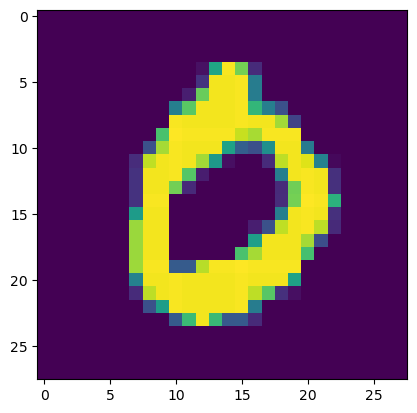

In [ ]:

# X, Y = next(iter(testloader))
# idx = 3
# plt.imshow(X[idx].squeeze())
# print(Y[idx])

In [97]:
def de(model, loader, device):
    model.eval()
    model.to(device)

    correct = 0
    total = 0
    
    with torch.no_grad():
        for X,Y in loader:
            X, Y = X.to(device), Y.to(device)
            logits = model(X)
        
            correct += torch.sum(logits.argmax(dim=1) == Y).item()
            total += len(Y)
    print(correct)
    print(total)
    return correct/total



x = torch.randn(1, *inp_shape)
# for mask, module in zip(circuit_0.masks, circuit_0.model.chain):
#     # print(mask)
#     x = mask(module(x))
#     print(x)
testloader, trainloader = train.load_dataset("mnist-circuit-0")
de(circuit_0, trainloader, device)

5000
10000


0.5

In [ ]:
def dead(model: torch.nn.Module, inp_shape: list[int]):
    dummy = torch.randn(inp_shape)
    return 0

In [21]:
# ce.analyze_disconnected_unmasked(circuit_0)

In [ ]:
circuit_1 = run_class_circuit(1, model)

In [ ]:
circuit_2 = run_class_circuit(2, model)

In [ ]:
circuit_3 = run_class_circuit(3, model)

In [ ]:
circuit_4 = run_class_circuit(4, model)

In [ ]:
circuit_5 = run_class_circuit(5, model)

In [ ]:
circuit_6 = run_class_circuit(6, model)

In [ ]:
circuit_7 = run_class_circuit(7, model)

In [ ]:
circuit_8 = run_class_circuit(8, model)

In [ ]:
circuit_9 = run_class_circuit(9, model)

### Finetuned layer

In [ ]:
print("\n--- Phase 2: Train Sparse Baseline ---")
train.finetune(
    model=model,
    num_classes=2,
    lr=cfg['baseline']['lr'],
    b1=0.9, b2=0.999,
    ds_name="mnist-circuit",
    eps=1e-8,
    epochs=cfg['baseline']['epochs'],
    device=device,
    seed=cfg['seed']
)


--- Phase 2: Train Sparse Baseline ---
n_params 23628 n_params_wd 23568


/home/cabbagepatch/miniconda3/envs/new/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(
/home/cabbagepatch/miniconda3/envs/new/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0 | Train Acc: 0.9357 | Test Acc: 0.9456
Epoch 1 | Train Acc: 0.9511 | Test Acc: 0.9550
Epoch 2 | Train Acc: 0.9436 | Test Acc: 0.9498


In [64]:
# 3. Extract Circuit
print("\n--- Phase 3: Extract Circuit ---")
# Note: We pass the *trained* model to the circuit extractor
cfg['circuit']['l0_lambda'] = 0.0001
cfg['circuit']['lr'] = 1e-2
cfg['circuit']['epochs'] = 20
circuit = train.extract_circuit(
    model=model,
    lr=cfg['circuit']['lr'],
    b1=0.9, b2=0.999,
    ds_name="mnist-circuit",
    eps=1e-8,
    epochs=cfg['circuit']['epochs'],
    device=device,
    l0_lambda=cfg['circuit']['l0_lambda'],
    seed=cfg['seed']
)


--- Phase 3: Extract Circuit ---
Calculating mean activations...


/home/cabbagepatch/miniconda3/envs/new/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(
/home/cabbagepatch/miniconda3/envs/new/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Initializing Circuit...
Extracting Circuit (L0 Lambda=0.0001)...
Epoch 0 | Loss: 4.3552 | Avg Mask: -1.278 | Total Non-Zero: 2337.0 | | Circuit Acc: 0.0434
Epoch 1 | Loss: 1.8895 | Avg Mask: -1.573 | Total Non-Zero: 1367.0 | | Circuit Acc: 0.5566
Epoch 2 | Loss: 1.6700 | Avg Mask: -1.780 | Total Non-Zero: 1140.0 | | Circuit Acc: 0.5740
Epoch 3 | Loss: 1.6140 | Avg Mask: -1.947 | Total Non-Zero: 971.0 | | Circuit Acc: 0.5545
Epoch 4 | Loss: 1.5956 | Avg Mask: -2.092 | Total Non-Zero: 911.0 | | Circuit Acc: 0.5580
Epoch 5 | Loss: 1.5883 | Avg Mask: -2.225 | Total Non-Zero: 867.0 | | Circuit Acc: 0.5582
Epoch 6 | Loss: 1.5836 | Avg Mask: -2.351 | Total Non-Zero: 821.0 | | Circuit Acc: 0.5423
Epoch 7 | Loss: 1.5765 | Avg Mask: -2.473 | Total Non-Zero: 773.0 | | Circuit Acc: 0.5486
Epoch 8 | Loss: 1.5830 | Avg Mask: -2.591 | Total Non-Zero: 755.0 | | Circuit Acc: 0.5336
Epoch 9 | Loss: 1.5876 | Avg Mask: -2.707 | Total Non-Zero: 740.0 | | Circuit Acc: 0.5346
Epoch 10 | Loss: 1.5878 | Avg Ma

In [73]:
x = circuit.masks[-6].mask.data

sum(x > 0) / x.numel()

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0003, 0.0006, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0006, 0.0000, 0.0003, 0.0000,
         0.0000, 0.0000, 0.0003, 0.0003, 0.0000],
        [0.0000, 0.0000, 0.0003, 0.0000, 0.0013, 0.0010, 0.0003, 0.0006, 0.0006,
         0.0000, 0.0000, 0.0003, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0016, 0.0022, 0.0013, 0.0016, 0.0000,
         0.0003, 0.0003, 0.0006, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0003, 0.0010, 0.0019, 0.0016, 0.0010, 0.0003,
         0.0000, 0.0000, 0.0006, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0006, 0.0010, 0.0013, 0.0013, 0.0013, 0.0003, 0.0000,
  